In [394]:
import scipy.io
import pandas as pd
import numpy as np
import numpy.matlib as npmat
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

In [346]:
# Loading data
train_5_dict = scipy.io.loadmat("training_data_5.mat")
train_5_arr = train_5_dict['train_data_5'];
test_5_dict = scipy.io.loadmat("testing_data_5.mat")
test_5_arr = test_5_dict['test_data_5'];

In [347]:
train_6_dict = scipy.io.loadmat("training_data_6.mat")
train_6_arr = train_6_dict['train_data_6'];
test_6_dict = scipy.io.loadmat("testing_data_6.mat")
test_6_arr = test_6_dict['test_data_6'];

<IPython.core.display.Javascript object>


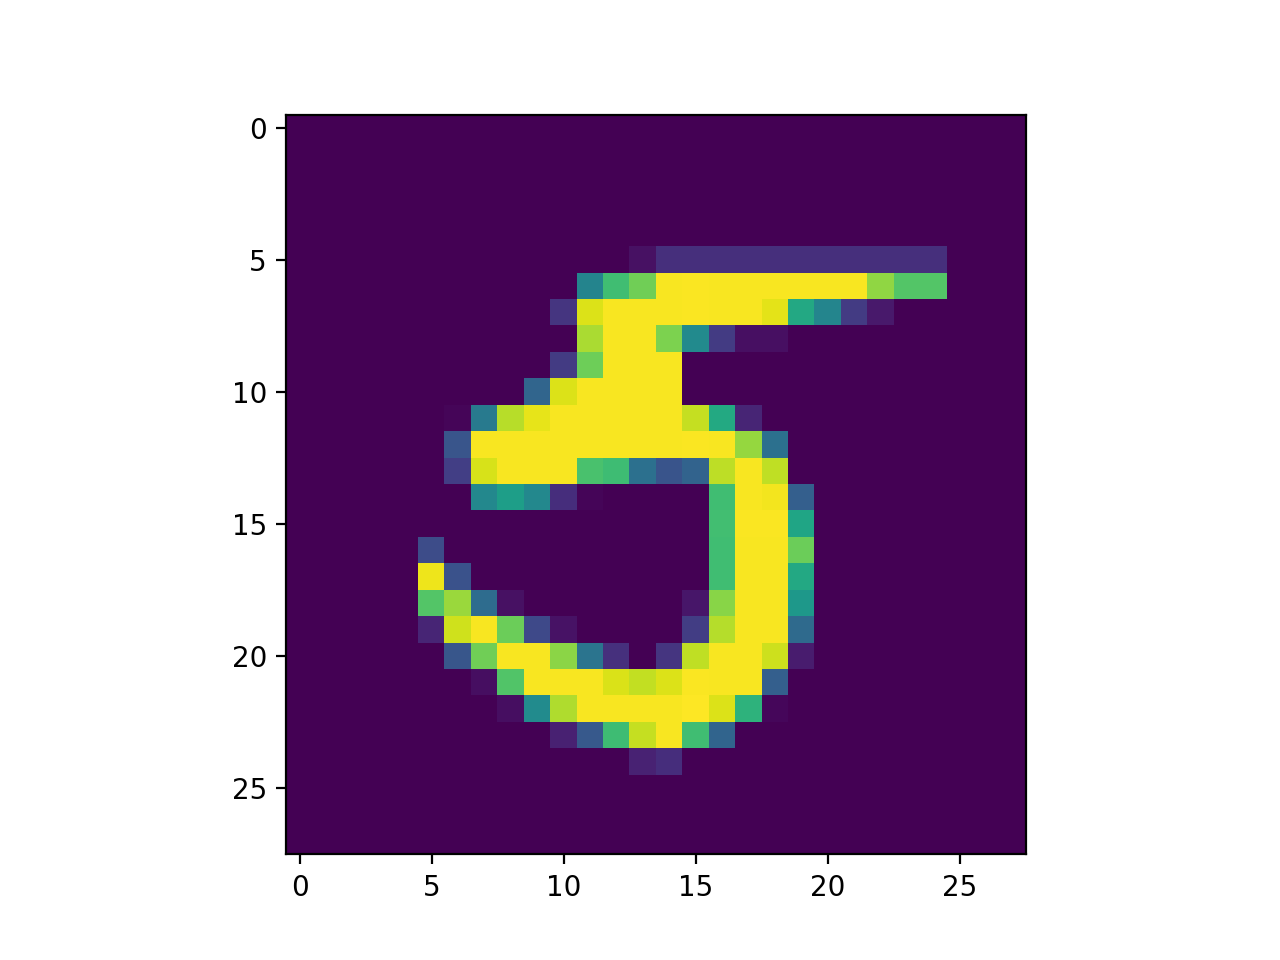

In [348]:
# Just to showcase how an MNIST image looks like
im1 = train_5_arr[500]
plt.imshow(im1)

## Vectorization

In [350]:
# Train
train_6_vect = train_6_arr.reshape(5918, 784)
train_5_vect = train_5_arr.reshape(5421, 784)
train_total_vect = np.vstack((train_5_vect, train_6_vect));

# Test
test_6_vect = test_6_arr.reshape(958, 784);
test_5_vect = test_5_arr.reshape(892, 784);
test_total_vect = np.vstack((test_5_vect, test_6_vect));

## Task 1: - Feature normalization

In [408]:
# Calculating mean and variance for training data.
# This would be used to normalize training as well as test data.
mean = np.mean(train_total_vect, axis = 0)
std = np.std(train_total_vect, axis = 0)

# Replacing very small std deviations with 1e-10, which got rounded off to 0 due to decimal constraints.
std[std == 0] = 0.0000000001;

In [409]:
# Train
mean_total_mat = npmat.repmat(mean, 11339, 1);
std_total_mat = npmat.repmat(std, 11339, 1);
train_total_norm = np.divide((train_total_vect - mean_total_mat), std_total_mat)


# Test
mean_test_mat = npmat.repmat(mean, 1850, 1);
std_test_mat = npmat.repmat(std, 1850, 1);
test_total_norm = np.divide((test_total_vect - mean_test_mat), std_test_mat)

## Task 2:- PCA using the training samples

In [355]:
# Computing the covariance matrix.
cov_mat_total = np.cov(train_total_norm , rowvar = False)

# Computing eigen vector and eigen values
eigen_values_total , eigen_vectors_total = np.linalg.eigh(cov_mat_total)

### Eigen analysis :-


In [389]:
# Sorting eigenvalues, and storing the sorted indices
sorted_index_total = np.argsort(eigen_values_total)[::-1]

# Sorted eigenvalues
sorted_eigenvalue_total = eigen_values_total[sorted_index_total]

# Sorting Eigenvectors according to sorted indices obtained while sorting eigenvalues
sorted_eigenvectors_total = eigen_vectors_total[:,sorted_index_total]

# Now, we need to select the first 2 eigenvectors, corresponding to the 2 largest eigenvalues.
numOfComponents = 2
# Projection Matrix
eigenvector_subset_total = sorted_eigenvectors_total[:,0:numOfComponents]

principleComponent1 = eigenvector_subset_total[:, 0];
principleComponent1 = eigenvector_subset_total[:, 1];

## Task 3:- Dimensionality Reduction using PCA

In [426]:
# Projecting the 784-d training data onto 2 orthogonal eigenvectors in 2-d.

# Train
train_reduced_total = np.dot(eigenvector_subset_total.transpose(),train_total_norm.transpose()).transpose();

# Test
# Note:- We project testing data onto the same 2 principle components obtained from PCA over training data.
test_reduced_total = np.dot(eigenvector_subset_total.transpose(),test_total_norm.transpose()).transpose();

<IPython.core.display.Javascript object>


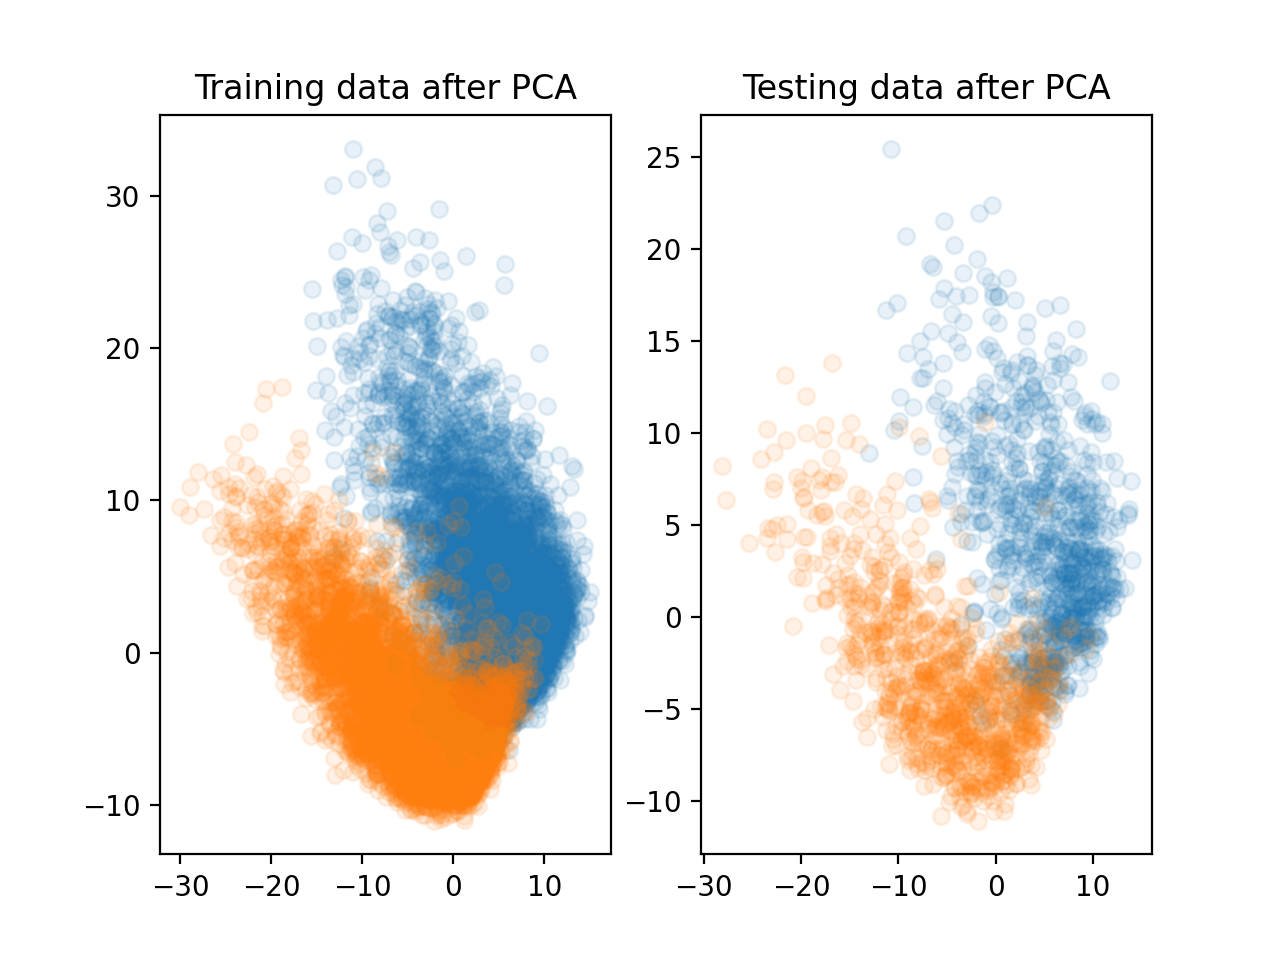

Text(0.5, 1.0, 'Testing data after PCA')

In [400]:
fig, axs = plt.subplots(1,2)

# Plotting reduced training data
axs[0].scatter(train_reduced_total[0:5421,0], train_reduced_total[0:5421,1], alpha = 0.1)
axs[0].scatter(train_reduced_total[5421:11338,0], train_reduced_total[5421:11338,1], alpha = 0.1)
axs[0].set_title('Training data after PCA')

# Plotting reduced testing data
axs[1].scatter(test_reduced_total[0:892,0], test_reduced_total[0:892,1], alpha = 0.1)
axs[1].scatter(test_reduced_total[892:,0], test_reduced_total[892:,1], alpha = 0.1)
axs[1].set_title('Testing data after PCA')

# Below plot hints at that the training and testing data is distributed normally.


<IPython.core.display.Javascript object>


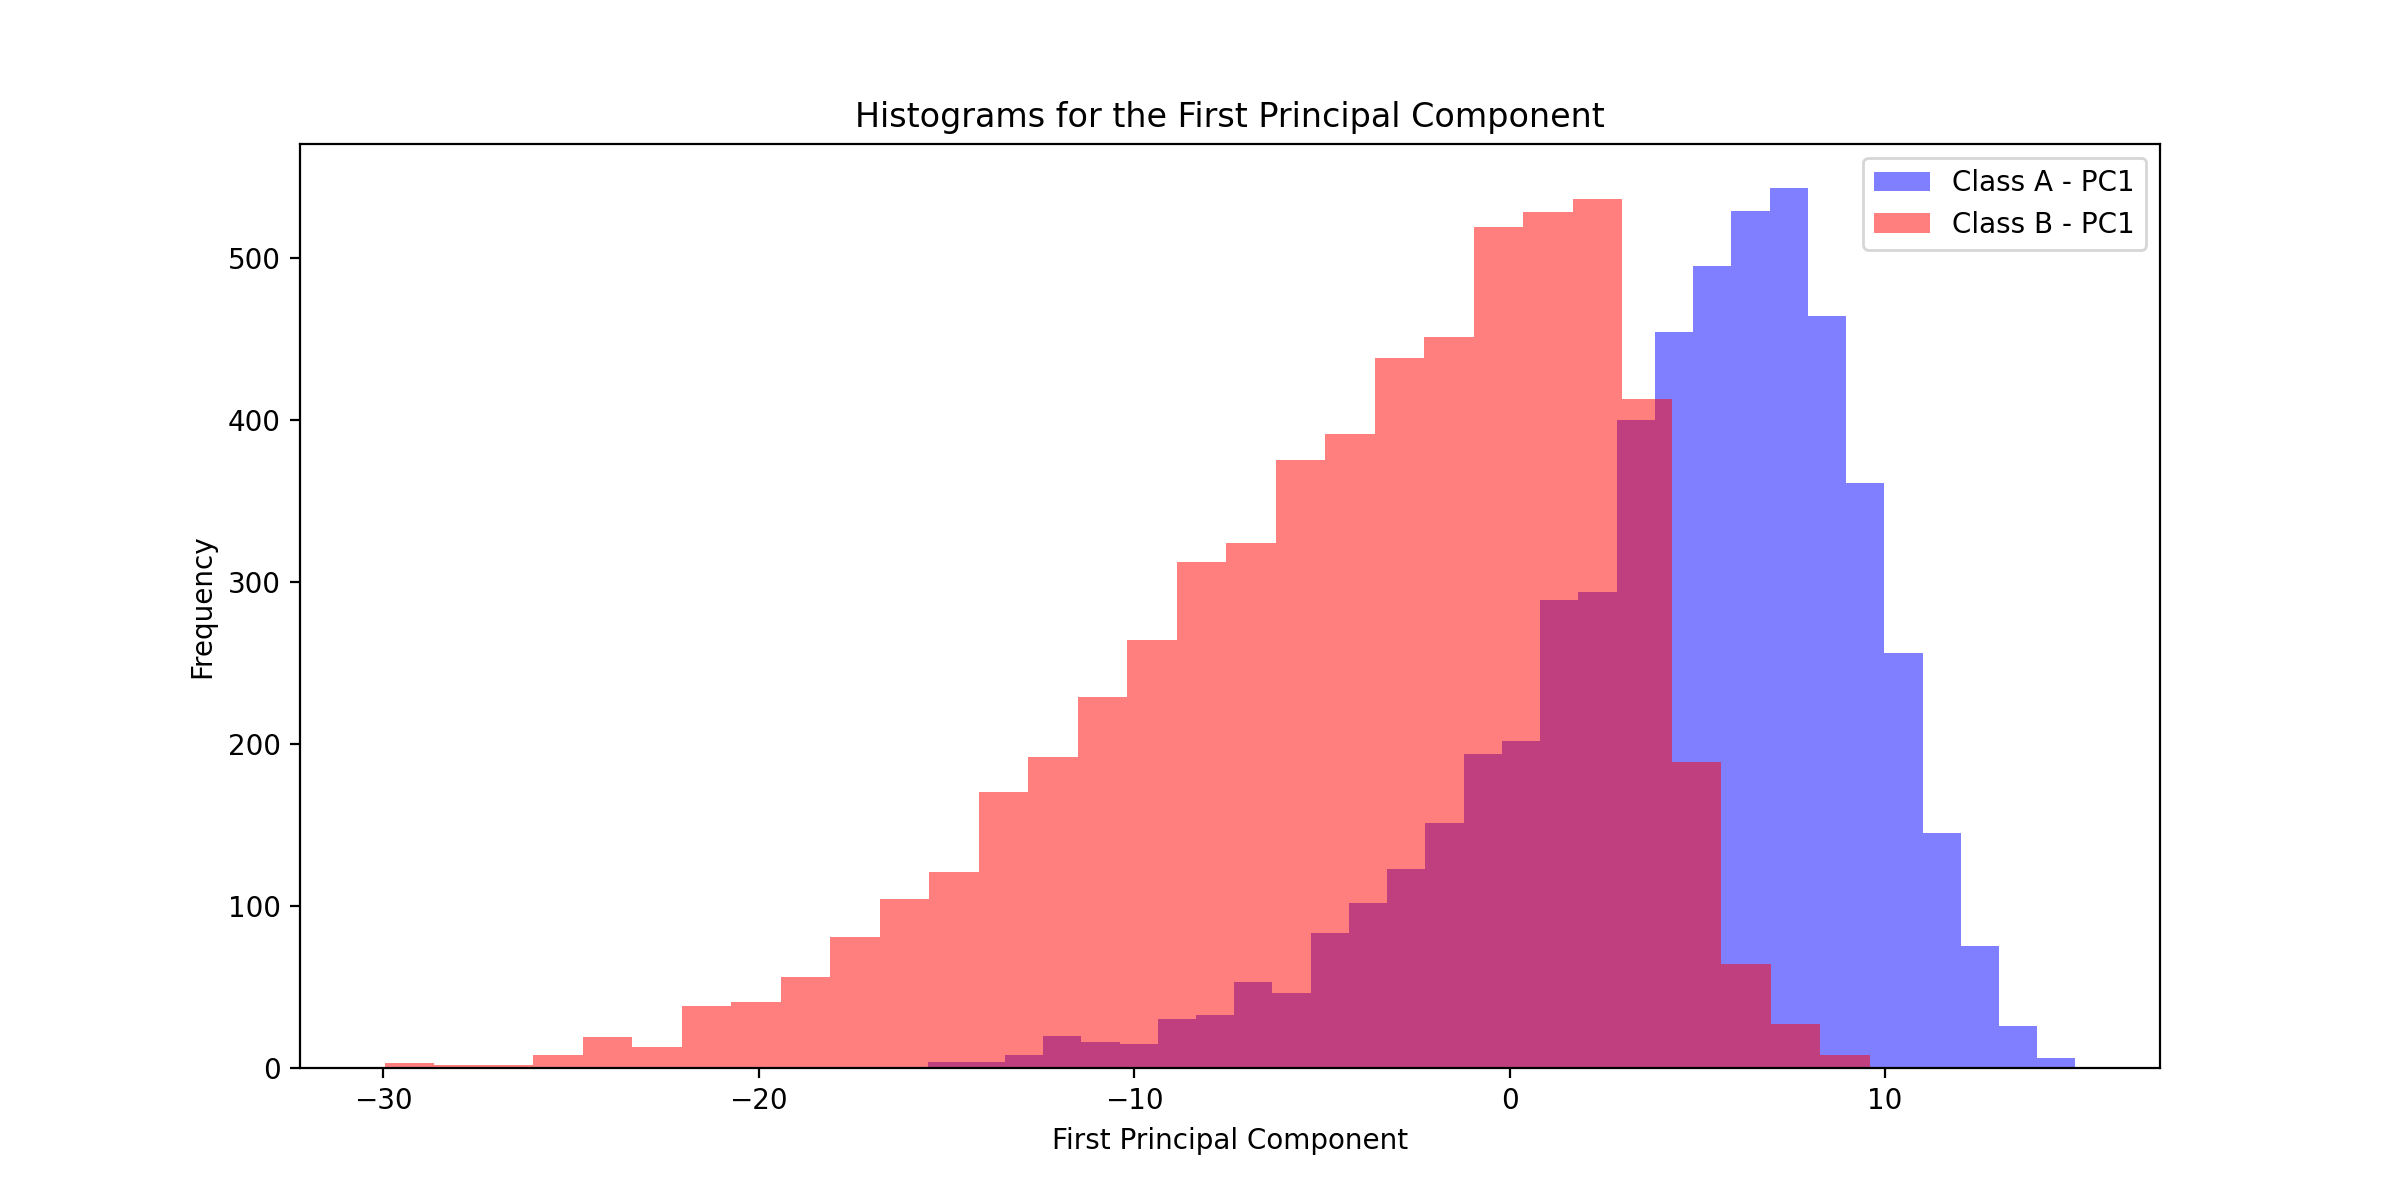

<IPython.core.display.Javascript object>


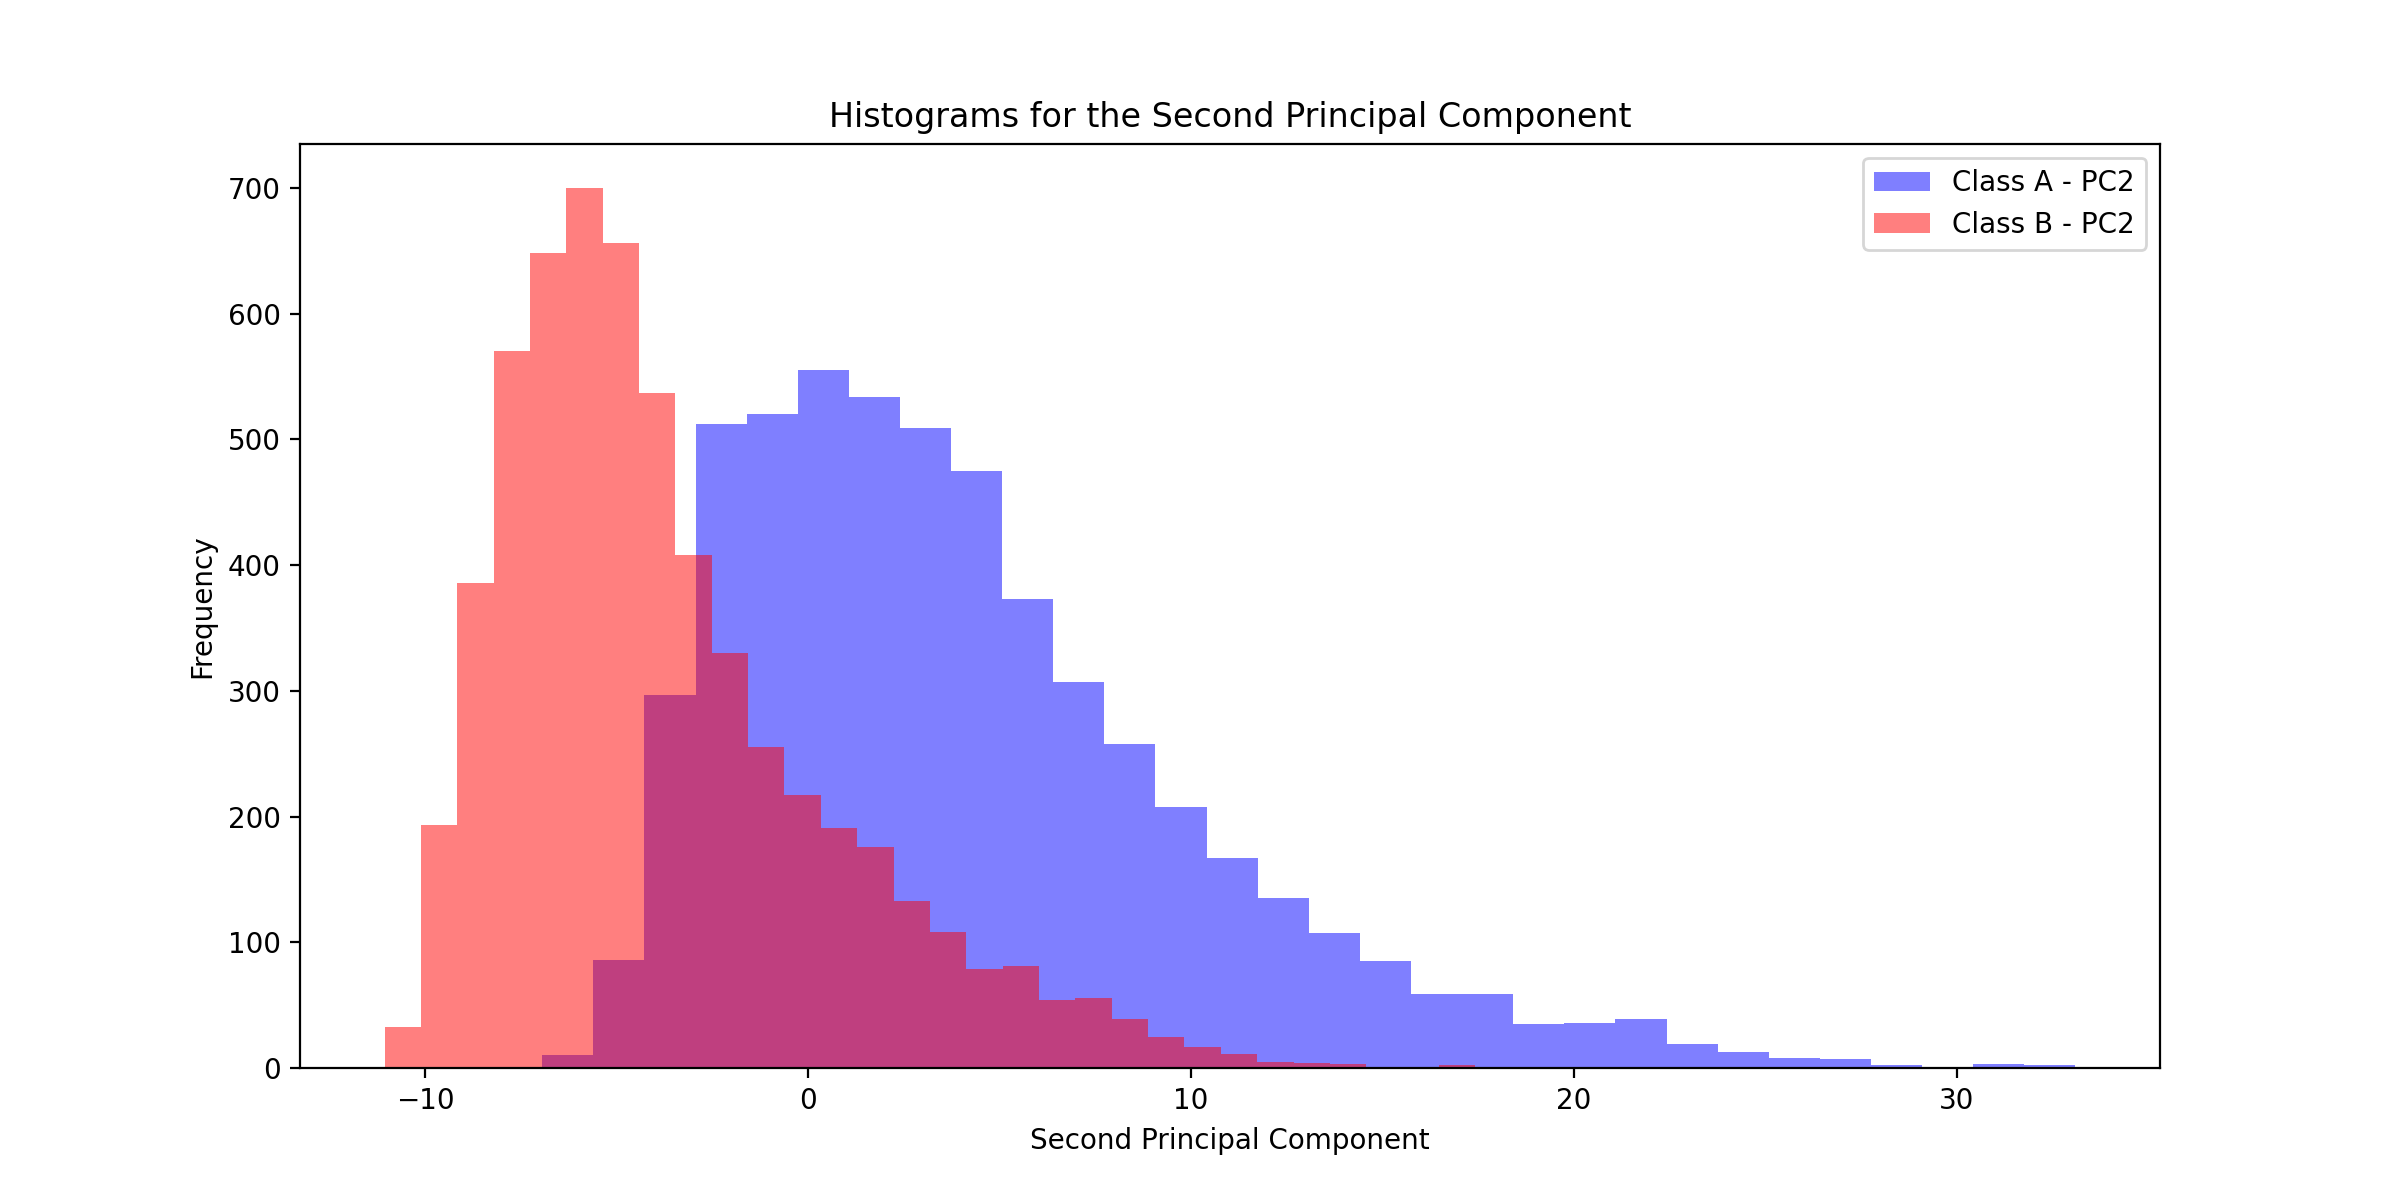

In [407]:
# plot pca
plt.figure(figsize=(12, 6))

# Plot histograms for Class A and Class B along the first principal component
plt.hist(train_reduced_total[:5421, 0], bins=30, alpha=0.5, color='blue', label='Class A - PC1')
plt.hist(train_reduced_total[5421:, 0], bins=30, alpha=0.5, color='red', label='Class B - PC1')

# Set labels and legend
plt.xlabel('First Principal Component')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.title('Histograms for the First Principal Component')
plt.show()

# Repeat the above steps for the second principal component

# Create histograms for the second principal component
plt.figure(figsize=(12, 6))

# Plot histograms for Class A and Class B along the second principal component
plt.hist(train_reduced_total[:5421, 1], bins=30, alpha=0.5, color='blue', label='Class A - PC2')
plt.hist(train_reduced_total[5421:, 1], bins=30, alpha=0.5, color='red', label='Class B - PC2')

# Set labels and legend
plt.xlabel('Second Principal Component')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.title('Histograms for the Second Principal Component')
plt.show()

### The above plots clearly show that the PCA projections for both classes. have a normal distribution.

## Task 4:- Density Estimation

In [410]:
def estimate_2d_normal_parameters(data):
    N = len(data)
    mean_estimate = np.zeros(2)
    for data_point in data:
        mean_estimate += data_point
    mean_estimate /= N

    cov_estimate = np.zeros((2, 2))
    for data_point in data:
        cov_estimate += np.outer(data_point - mean_estimate, data_point - mean_estimate)
    cov_estimate /= N

    return mean_estimate, cov_estimate


In [412]:
# Estimate the parameters of the 2D normal distribution
mean_estimate_5, cov_estimate_5 = estimate_2d_normal_parameters(train_reduced_total[0:5421, :])
mean_estimate_6, cov_estimate_6 = estimate_2d_normal_parameters(train_reduced_total[5421:, :])

## Task 5:- Bayesian Decision Theory for optimal classification

In [428]:
# Adding labels to training and testing data
# Train
train_reduced_total = np.hstack((train_reduced_total, np.zeros((11339, 1))))
train_reduced_total[5421:, 2] = 1

# Test
test_reduced_total = np.hstack((test_reduced_total, np.zeros((1850, 1))))
test_reduced_total[892:, 2] = 1

In [429]:
def calculate_pdf(point, mean, covariance_matrix):
    pdf = multivariate_normal.pdf(point, mean=mean, cov=covariance_matrix)
    return pdf

In [430]:
def classify_point(point, mean_1, mean_2, covMat_1, covMat_2):
    # Calculate the probabilities for each class
    pdf_class1 = calculate_pdf(point, mean_1, covMat_1)
    pdf_class2 = calculate_pdf(point, mean_2, covMat_2)
    
    # Assign the point to the class with the higher probability
    if pdf_class1 > pdf_class2:
        return 0  # Class 0
    else:
        return 1  # Class 1

In [433]:
# Classify the training set and calculate accuracy
correct_train = 0
for point in train_reduced_total:
    true_class = point[-1]  # Assuming the class label is the last column
    predicted_class = classify_point(point[:-1], mean_estimate_5, mean_estimate_6, cov_estimate_5, cov_estimate_6)  # Exclude the class label for classification
    if true_class == predicted_class:
        correct_train += 1
        
accuracy_train = (correct_train / len(train_reduced_total)) * 100
        
# Classify the testing set and calculate accuracy
correct_test = 0
for point in test_reduced_total:
    true_class = point[-1]  # Assuming the class label is the last column
    predicted_class = classify_point(point[:-1], mean_estimate_5, mean_estimate_6, cov_estimate_5, cov_estimate_6)  # Exclude the class label for classification
    if true_class == predicted_class:
        correct_test += 1

accuracy_test = (correct_test / len(test_reduced_total)) * 100

print("Training accuracy in % :-", accuracy_train)
print("Testing accuracy in % :-", accuracy_test)

Training accuracy in % :- 94.27639121615663
Testing accuracy in % :- 93.83783783783784
